<a href="https://colab.research.google.com/github/RoshanM-18/Intermediate-Deep-Learning-projects-using-Tensorflow-Keras/blob/main/Putting_together_everything_you_know_about_se2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn

import tensorflow as tf
from tensorflow import keras

import os
import shutil
import zipfile
import time
import random

#### Some thoughts about LSTM model

1. there is a difference between `return_sequences` and `return_states` in LSTM model.
2. `return_sequences` returns **the hidden state output for each input time step**
3. `return_states` returns **hidden state output and cell state for the last input step**
4. `return_sequences` and `return_states` can be used at the same time. 

* Each cell within the `LSTM()` layer has an internal cell state called "**c**" and outputs a hidden state called "**h**"
* the output of a LSTM cell is called the hidden state or "**h**"
* Each LSTM cell retains an internal state that is not output is called the cell state or "**c**"


Generally, we do not need to access the cell state unless we are developing the encoder-decoder model where subsequent layers may need to have their cell state initialized with the final cell state of another layer 

Some basic notes 
> the input for LSTMs must be 3D. We can reshape the 2D sequence into a 3D sequence with `(n_samples, 1_time_step, n_features)` and the output as `(n_samples, n_features)`

In [ ]:
# a lstm model without return_sequences set to True

inputs1 = keras.layers.Input(shape=(3,1))
lstm = keras.layers.LSTM(1)(inputs1)
model = keras.Model(inputs=inputs1, outputs=lstm)

data = np.array([0.1, 0.2, 0.3]).reshape((1,3,1))
model.predict(data)

# output is single hidden state for the input sequence with three time steps

array([[0.02357047]], dtype=float32)

In [ ]:
# a lsrm model with return_sequences set to True
# with return_sequences set to True, it is possible to access the hidden state output for each input time step

inputs2 = keras.layers.Input(shape=(3,1))
lstm = keras.layers.LSTM(1, return_sequences=True)(inputs2)
model = keras.Model(inputs=inputs2, outputs=lstm)

data = np.array([0.1, 0.2, 0.3]).reshape((1,3,1))
model.predict(data)

# it returns a sequence of 3 values one hidden state output for each input time step for single LSTM layer in the cell
# remember to set return_sequences = True while stacking LSTMs

array([[[0.01158469],
        [0.03311922],
        [0.06350742]]], dtype=float32)

In [ ]:
# a lstm model with return_states set to True

inputs3 = keras.layers.Input(shape=(3,1))
lstm, state_h, state_c = keras.layers.LSTM(1, return_state=True)(inputs3)
model = keras.Model(inputs=inputs3, outputs=[lstm, state_h, state_c])

data = np.array([0.1, 0.2, 0.3]).reshape((1,3,1))
model.predict(data)

# this model returns the lstm hidden state output for the last time step, the lstm hidden state output for the last time step (again) and
# the lstm cell state for the last time step

# the hidden state and the cell state could in turn be used to initialize the states of another LSTM layer with the same number of cells.

[array([[0.08875267]], dtype=float32),
 array([[0.08875267]], dtype=float32),
 array([[0.17953661]], dtype=float32)]

In [ ]:
# a lstm model with return_sequences and return_states set to True

inputs4 = keras.layers.Input(shape=(3,1))
lstm, state_h, state_c = keras.layers.LSTM(1, return_sequences=True, return_state=True)(inputs4)
model = keras.Model(inputs=inputs4, outputs=[lstm, state_h, state_c])

data = np.array([0.1, 0.2, 0.3]).reshape((1,3,1))
model.predict(data)

# this returns the hidden state for each input time step and then seperately the hidden state output for the last time step and the
# cell state for the last time step.

[array([[[0.02282514],
         [0.06736648],
         [0.13170806]]], dtype=float32),
 array([[0.13170806]], dtype=float32),
 array([[0.23579516]], dtype=float32)]

#### Some thoughts about using the `TimeDistributed()` layer with the `LSTM()` layer

*`TimeDistributedDense` applies a same Dense (fully-connected) operation to every timestep of a 3D tensor* - fchollet 

1. When using a `TimeDistributed` layer the input must be atleast 3D, meaning you need to configure your last LSTM layer prior to your TimeDistributed wrapped Dense layer to `return_sequences = True`
2. The output will be 3D that means if your TimeDistributed wrapped Dense layer is your output layer and youre predicting a sequence, you will need to resize your y array into a 3D array. 

In [ ]:
# one to one LSTM for sequence prediction

X = np.array([0.2, 0.4, 0.6, 0.8, 1.0]).reshape((5,1,1))
y = np.array([0.2, 0.4, 0.6, 0.8, 1.0]).reshape((5,1))

model = keras.Sequential()
model.add(keras.layers.LSTM(5, input_shape=(1,1)))
model.add(keras.layers.Dense(1))

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())

model.fit(X, y, epochs=1000, batch_size=5)

In [ ]:
result = model.predict(X, batch_size=5)
result

array([[0.27702516],
       [0.43748283],
       [0.60833174],
       [0.7798357 ],
       [0.9442926 ]], dtype=float32)

In [ ]:
X

array([[[0.2]],

       [[0.4]],

       [[0.6]],

       [[0.8]],

       [[1. ]]])

In [ ]:
y

array([[0.2],
       [0.4],
       [0.6],
       [0.8],
       [1. ]])

In [ ]:
# many to one LSTM for sequence prediction (without time distributed)

X = np.array([0.2, 0.4, 0.6, 0.8, 1.0]).reshape((5,1,1))
y = np.array([0.2, 0.4, 0.6, 0.8, 1.0]).reshape((5,1))

model = keras.Sequential([
    keras.layers.LSTM(5, input_shape=(1,1)),
    keras.layers.Dense(5)
])

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())

model.fit(X, y, epochs=500, batch_size=5)

In [ ]:
result = model.predict(X, batch_size=5)
result

array([[0.39219046, 0.4155471 , 0.42751342, 0.4222175 , 0.41664994],
       [0.51225156, 0.5208384 , 0.52611774, 0.5223061 , 0.52449894],
       [0.6301034 , 0.6290431 , 0.6265464 , 0.6203565 , 0.6276293 ],
       [0.74155086, 0.73695576, 0.72587836, 0.7125983 , 0.7221887 ],
       [0.8441053 , 0.84194493, 0.8218107 , 0.79690355, 0.8062953 ]],
      dtype=float32)

In [ ]:
# many to one LSTM for sequence prediction (with TimeDistributed)

X = np.array([0.2, 0.4, 0.6, 0.8, 1.0]).reshape((1, 5, 1))
y = np.array([0.2, 0.4, 0.6, 0.8, 1.0]).reshape((1, 5, 1))

32 -> i , i am, i am roshan, 

[32] ->
# because of return_sequences set to True, it has an effect of each LSTM unit returning a sequence of 5 outputs, each for one time step in 
# the input data, instead of single output as shown in the previous example

# We can use the time distributed layer on the output layer to wrap a fully connected dense layer with a single output
# the single output value in the output layer is the KEY
# it means that we intend to output one time step from the sequence for each time step in the input
# it just so appears as we will process 5 time steps of the input sequence at a time

model = keras.Sequential([
    keras.layers.LSTM(5, input_shape=(5, 1), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
])

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())

model.fit(X, y, epochs=1000, batch_size=1)

In [ ]:
result = model.predict(X, batch_size=1)
result

array([[[0.24756636],
        [0.39840063],
        [0.5905745 ],
        [0.80437714],
        [0.9952152 ]]], dtype=float32)

In [ ]:
X

array([[[0.2],
        [0.4],
        [0.6],
        [0.8],
        [1. ]]])

In [ ]:
y

array([[[0.2],
        [0.4],
        [0.6],
        [0.8],
        [1. ]]])

#### Notes about Encoder-decoder model for sequence to sequence prediction 

1. the **encoder-decoder** model is a way of organizing RNN for sequence to sequence prediction problems
2. the approach involves two RNNs, one to *encode the source sequence called the encoder* and second to *decode the encoded source sequence into target sequence called the decoder*

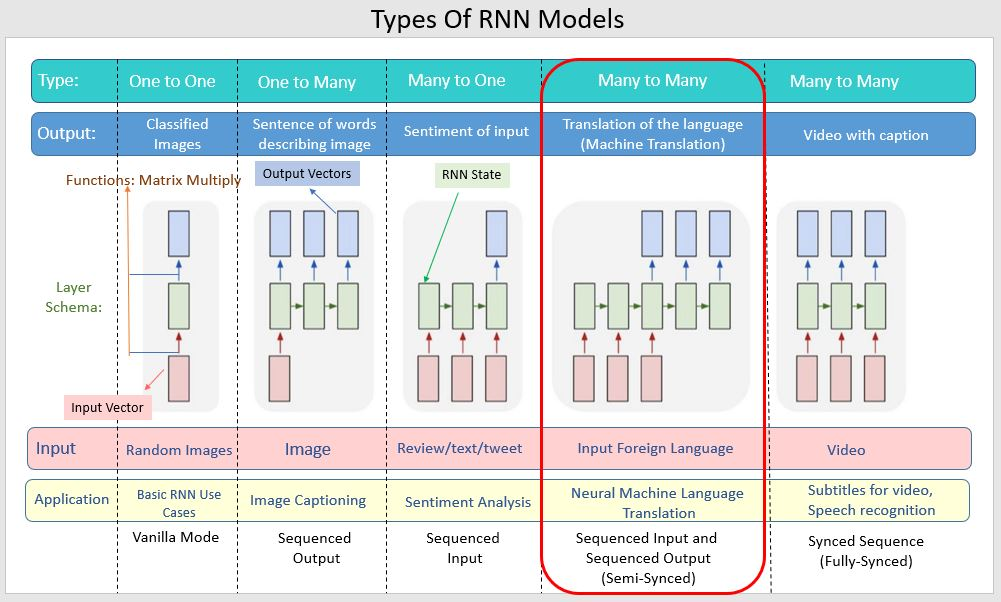

In [ ]:
num_encoder_tokens = 71
num_decoder_tokens = 93
latent_dim = 256

encoder_inputs = keras.layers.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# we discard encoder_outputs and only keep the states
encoder_states = [state_h, state_c]

# set up the decoder using encoder_states as initial state
decoder_inputs = keras.layers.Input(shape=(None, num_decoder_tokens))
# we set up our decoder to return full output sequences and to return internal states as well
# we dont use the return states in the training model but we will use them in inference
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

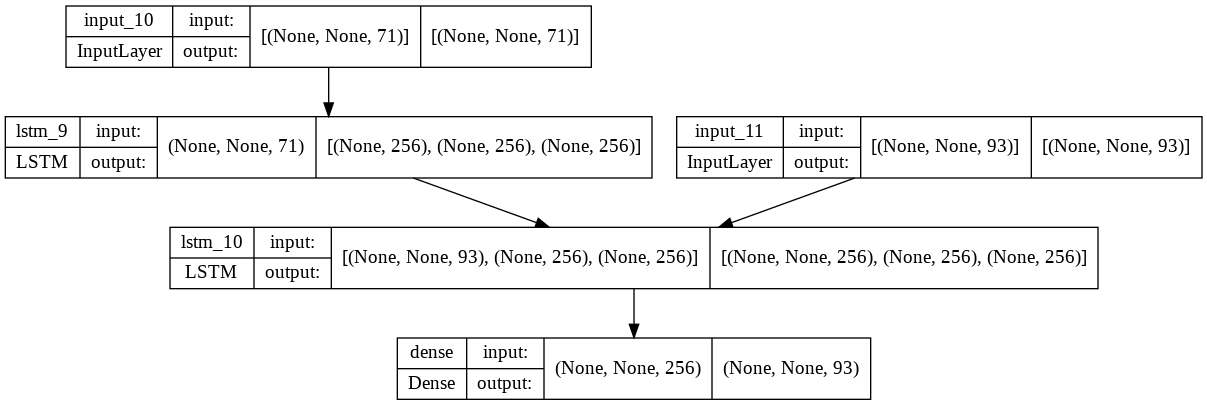

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)